# First simulation 

In this notebook, we run some experiments on **Tumor Growth** simulated data.

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import matplotlib.pyplot as plt
from time import time

import warnings
warnings.filterwarnings('ignore')

### Data generation & preprocessing

***Generate longitudinal markers***

In [2]:
from data_loader import load_Tumor_Growth
paths, surv_labels, ddh_info_sup = load_Tumor_Growth.load()
n_samples, n_sampling_times, _ = paths.shape
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]

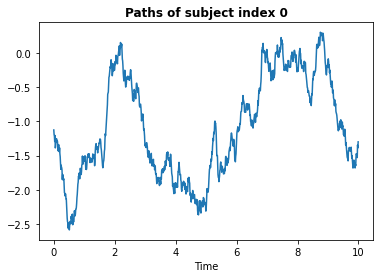

In [3]:
# plot time series of subject index 0
idx = 0
plt.plot(sampling_times, paths[idx,:,1:])
plt.xlabel("Time")
plt.ylabel("")
plt.title("Paths of subject index 0", fontweight="bold", size=12)
plt.show()

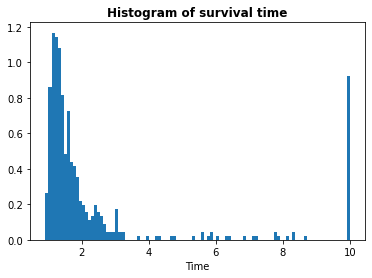

In [4]:
plt.hist(surv_times, bins=100, density=True)
plt.xlabel("Time")
plt.title("Histogram of survival time", fontweight="bold")
plt.show()

In [5]:
#Number of individuals
print("Number of samples ", paths.shape[0])
#Number of individuals
print("Number of longitudinal markers ", paths.shape[2])
#Censoring level
print("Censoring level {}%".format(((1 - sum(surv_inds) / len(surv_inds)) * 100).round(1)))

Number of samples  500
Number of longitudinal markers  2
Censoring level 8.4%


***Masking***

We need to flatten the curves that appear after the event for the train test. First we have to put the events on the time grid.

In [6]:
# index of individuals for whom the event occurs
occuring_event_index = np.where(surv_labels[:,1] == 1)[0]
for idx in occuring_event_index:
    time_index = np.searchsorted(sampling_times, surv_labels[idx, 0])
    if time_index < n_sampling_times:
        paths[idx, time_index:, 1:] = paths[idx, time_index, 1:]

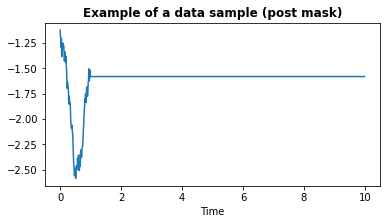

In [7]:
idx = 0
plt.figure(figsize=(6, 3))
plt.plot(sampling_times, paths[idx, :, 1:])
plt.title("Example of a data sample (post mask)", fontweight="bold")
plt.xlabel("Time")
plt.show()

***Setup for prediction***

In [8]:
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.05, .1, .2])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .05) - pred_times))
eval_times = np.array(eval_times)

***Split train-test data***

In [9]:
train_test_share = .8
n_samples = paths.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

paths_train = paths[train_index, :, :]
surv_labels_train = surv_labels[train_index, :]

paths_test = paths[test_index, :, :]
surv_labels_test = surv_labels[test_index, :]

### Neural Controlled Differential Equation (NCDE)

epoch: 0, objective: 9.983168244361877
epoch: 1, objective: 9.217172980308533
epoch: 2, objective: 8.749583840370178
epoch: 3, objective: 8.418651461601257
epoch: 4, objective: 8.148587346076965
epoch: 5, objective: 7.916632890701294
epoch: 6, objective: 7.727693438529968
epoch: 7, objective: 7.582717537879944
epoch: 8, objective: 7.463485479354858
epoch: 9, objective: 7.354385256767273
epoch: 10, objective: 7.253300666809082
epoch: 11, objective: 7.157348394393921
epoch: 12, objective: 7.060892224311829
epoch: 13, objective: 6.9611475467681885
epoch: 14, objective: 6.858274817466736
epoch: 15, objective: 6.75324821472168
epoch: 16, objective: 6.647628009319305
epoch: 17, objective: 6.544243037700653
epoch: 18, objective: 6.4473772048950195
epoch: 19, objective: 6.362648069858551
epoch: 20, objective: 6.296633422374725
epoch: 21, objective: 6.245886862277985
epoch: 22, objective: 6.194214165210724
epoch: 23, objective: 6.144563853740692
epoch: 24, objective: 6.096919119358063
epoch: 25

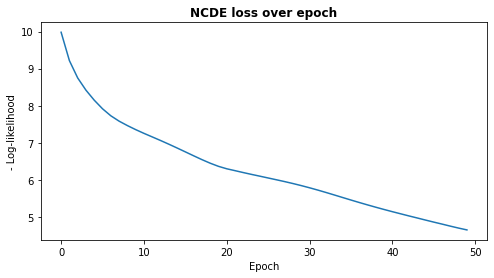

In [10]:
from src.cresnet import ControlledResNet

latent_dim = 4
hidden_dim = 128
path_dim = paths_train.shape[-1]
activation = 'tanh'
n_layers=2
learning_rate = 1e-4
batch_size = 64
num_epochs = 50
ncde = ControlledResNet(latent_dim, hidden_dim, path_dim, 
                        activation, n_layers, sampling_times)
ncde_optimizer = torch.optim.Adam(ncde.parameters(),
                                  lr=learning_rate)
start = time()
ncde.train(ncde_optimizer, paths_train, surv_labels_train, 
           batch_size, num_epochs, verbose=True)
ncde_bs = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
ncde_cindex = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
ncde_auc = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
ncde_time = time() - start

### Cox Signature

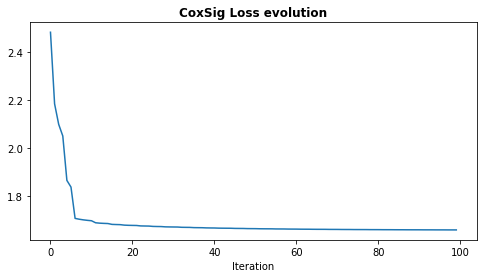

In [11]:
from src.coxsig import CoxSignature
# model with unnormalized features
start = time()
coxsig = CoxSignature(sig_level=2, alphas=1e-5, max_iter=100, plot_loss=True)
coxsig.train(paths_train, surv_labels_train)
coxsig_bs = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxsig_cindex = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxsig_auc = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxsig_time = time() - start

### Cox Signature Extension

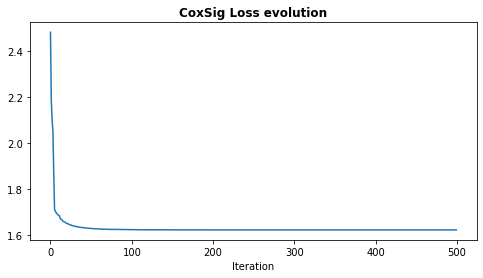

In [12]:
start = time()
coxsigext = CoxSignature(sig_level=2, alphas=1e-5, max_iter=500, plot_loss=True, ext_ver=True)
coxsigext.train(paths_train, surv_labels_train)
coxsigext_bs = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxsigext_cindex = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxsigext_auc = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxsigext_time = time() - start

### Competing methods ###

### CoxFirst

In [13]:
from competing_methods.coxfirst import CoxFirst
start = time()
coxfirst = CoxFirst(alphas=np.array([1e-3]))
coxfirst.train(paths_train, surv_labels_train)
coxfirst_bs = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxfirst_cindex = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxfirst_auc = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxfirst_time = time() - start

### RSF

In [14]:
from competing_methods.rsf import RSF
start = time()
rsf = RSF()
rsf.train(paths_train, surv_labels_train)
rsf_bs = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
rsf_cindex = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
rsf_auc = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
rsf_time = time() - start

### Dynamic-DeepHit

In [15]:
from competing_methods.dynamic_deephit_ext import construct_df, Dynamic_DeepHit_ext
from src.utils import score

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead o

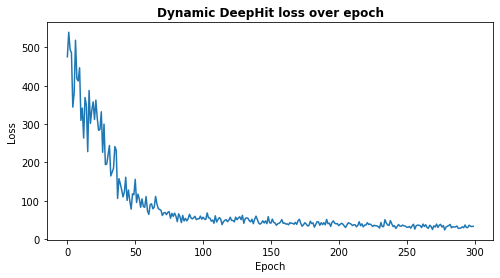

In [16]:
start = time()
# set-up for Dynamic DeepHit
cont_feat, bin_feat, time_scale, bin_df = ddh_info_sup
df = construct_df(paths.clone(), surv_labels, cont_feat, bin_feat, time_scale, bin_df)
dynamic_deephit = Dynamic_DeepHit_ext()
(data, time_, label), (mask1, mask2, mask3), (data_mi) = dynamic_deephit.preprocess(df, cont_feat)

# split data
tr_data, te_data = data[train_index, :, :], data[test_index, :, :]
tr_data_mi, te_data_mi = data_mi[train_index, :, :], data_mi[test_index, :, :]
tr_time,te_time = time_[train_index, :], time_[test_index, :]
tr_label,te_label = label[train_index, :], label[test_index, :]
tr_mask1,te_mask1 = mask1[train_index, :, :], mask1[test_index, :, :]
tr_mask2,te_mask2 = mask2[train_index, :, :], mask2[test_index, :, :]
tr_mask3,te_mask3 = mask3[train_index, :], mask3[test_index, :]

tr_data_full = (tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)

# train
dynamic_deephit.train(tr_data_full, sess_path=".", is_trained=False)

# predict
pred_time_scale = (pred_times * time_scale).astype(int)
eval_time_scale = (eval_times * time_scale).astype(int)
ddh_surv_preds = dynamic_deephit.predict(te_data, te_data_mi, 
                                         pred_time_scale, eval_time_scale)

n_pred_times = len(pred_times)
n_eval_times = len(eval_times)
ddh_bs = np.zeros((n_pred_times, n_eval_times))
ddh_cindex = np.zeros((n_pred_times, n_eval_times))
ddh_auc = np.zeros((n_pred_times, n_eval_times))
for j in np.arange(n_pred_times):
    pred_time = pred_times[j]
    
    # remove individuals whose survival time less than prediction time
    surv_times_test = surv_labels_test[:, 0]
    surv_inds_test = surv_labels_test[:, 1]
    idx_sel = surv_times_test >= pred_time
    surv_times_ = surv_times_test[idx_sel] - pred_time
    surv_inds_ = surv_inds_test[idx_sel]
    surv_labels_ = np.array([surv_times_, surv_inds_]).T
    surv_preds_ = ddh_surv_preds[:, j][idx_sel]

    ddh_bs[j] = score("bs", surv_labels_, surv_labels_, 
                      surv_preds_, eval_times)
    ddh_cindex[j] = score("c_index", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)
    ddh_auc[j] = score("auc", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)

ddh_time = time() - start

***Performace evaluation***

***C_index***

In [20]:
import prettytable
from prettytable import PrettyTable
cindex_table = PrettyTable()
cindex_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    cindex_table.add_row(["", "NCDE"] + ncde_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "CoxSig"] + coxsig_cindex[i].round(3).tolist())
    cindex_table.add_row([t, "CoxSigExt"] + coxsigext_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "CoxFirst"] + coxfirst_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "RSF"] + rsf_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "Dyn_DeepHit"] + ddh_cindex[i].round(3).tolist())
    cindex_table.add_row([""]*5)
print(cindex_table)

+-------+-------------+-------------+-------------+-------------+
|  p_t  |    Model    | d_t = 0.051 | d_t = 0.097 | d_t = 0.131 |
+-------+-------------+-------------+-------------+-------------+
|       |     NCDE    |    0.918    |    0.909    |    0.868    |
|       |    CoxSig   |    0.766    |    0.732    |    0.756    |
| 1.038 |  CoxSigExt  |    0.955    |    0.908    |    0.908    |
|       |   CoxFirst  |    0.918    |    0.909    |    0.868    |
|       |     RSF     |    0.903    |    0.909    |    0.871    |
|       | Dyn_DeepHit |    0.987    |    0.978    |     0.98    |
|       |             |             |             |             |
|       |     NCDE    |     0.86    |    0.828    |    0.846    |
|       |    CoxSig   |    0.722    |    0.762    |     0.72    |
|  1.09 |  CoxSigExt  |    0.873    |    0.887    |    0.844    |
|       |   CoxFirst  |    0.865    |    0.835    |    0.851    |
|       |     RSF     |    0.774    |    0.707    |    0.843    |
|       | 

***Brier-score***

In [22]:
import prettytable
from prettytable import PrettyTable
bs_table = PrettyTable()
bs_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    bs_table.add_row(["", "NCDE"] + ncde_bs[i].round(3).tolist())
    bs_table.add_row(["", "CoxSig"] + coxsig_bs[i].round(3).tolist())
    bs_table.add_row([t, "CoxSigExt"] + coxsigext_bs[i].round(3).tolist())
    bs_table.add_row(["", "CoxFirst"] + coxfirst_bs[i].round(3).tolist())
    bs_table.add_row(["", "RSF"] + rsf_bs[i].round(3).tolist())
    bs_table.add_row(["", "Dyn_DeepHit"] + ddh_bs[i].round(3).tolist())
    bs_table.add_row([""]*5)
print(bs_table)

+-------+-------------+-------------+-------------+-------------+
|  p_t  |    Model    | d_t = 0.051 | d_t = 0.097 | d_t = 0.131 |
+-------+-------------+-------------+-------------+-------------+
|       |     NCDE    |    0.049    |    0.091    |    0.125    |
|       |    CoxSig   |    0.048    |    0.106    |    0.154    |
| 1.038 |  CoxSigExt  |    0.046    |     0.1     |    0.143    |
|       |   CoxFirst  |    0.041    |    0.079    |    0.115    |
|       |     RSF     |    0.039    |    0.069    |    0.106    |
|       | Dyn_DeepHit |     0.05    |    0.117    |     0.18    |
|       |             |             |             |             |
|       |     NCDE    |    0.077    |    0.123    |    0.127    |
|       |    CoxSig   |     0.09    |    0.156    |    0.175    |
|  1.09 |  CoxSigExt  |    0.088    |     0.15    |    0.165    |
|       |   CoxFirst  |    0.078    |    0.129    |    0.123    |
|       |     RSF     |    0.076    |    0.129    |    0.122    |
|       | 

***AUC***

In [24]:
import prettytable
from prettytable import PrettyTable
auc_table = PrettyTable()
auc_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    auc_table.add_row(["", "NCDE"] + ncde_auc[i].round(3).tolist())
    auc_table.add_row(["", "CoxSig"] + coxsig_auc[i].round(3).tolist())
    auc_table.add_row([t, "CoxSigExt"] + coxsigext_auc[i].round(3).tolist())
    auc_table.add_row(["", "CoxFirst"] + coxfirst_auc[i].round(3).tolist())
    auc_table.add_row(["", "RSF"] + rsf_auc[i].round(3).tolist())
    auc_table.add_row(["", "Dyn_DeepHit"] + ddh_auc[i].round(3).tolist())
    auc_table.add_row([""]*5)
print(auc_table)

+-------+-------------+-------------+-------------+-------------+
|  p_t  |    Model    | d_t = 0.051 | d_t = 0.097 | d_t = 0.131 |
+-------+-------------+-------------+-------------+-------------+
|       |     NCDE    |    0.921    |    0.928    |    0.889    |
|       |    CoxSig   |    0.771    |    0.741    |    0.785    |
| 1.038 |  CoxSigExt  |    0.958    |     0.92    |    0.937    |
|       |   CoxFirst  |    0.921    |    0.928    |    0.889    |
|       |     RSF     |    0.907    |    0.928    |    0.897    |
|       | Dyn_DeepHit |    0.989    |    0.982    |    0.995    |
|       |             |             |             |             |
|       |     NCDE    |    0.866    |    0.845    |    0.883    |
|       |    CoxSig   |    0.738    |    0.797    |    0.741    |
|  1.09 |  CoxSigExt  |    0.894    |    0.932    |    0.877    |
|       |   CoxFirst  |    0.873    |    0.851    |    0.888    |
|       |     RSF     |    0.807    |    0.758    |    0.882    |
|       | 